**EUR/USD IN 1-hour TIMEFRAME PREDICTION USING LSTM MODEL**

4 May 2010 to 30 December 2019 data are used as training set and 2 january 2020 to 19 october 2020 data are used as testing set. This test aims to evaluate model's performance and to get best hyperparameters from it 

In [8]:
#import library

from google.colab import files
import tensorflow as tf  
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error
import random as python_random
import datetime

In [9]:
#mount drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
#read data to pandas dataframe

path = "drive/My Drive/Colab Notebooks/EURUSD1hour.csv"
data = pd.read_csv(path, names=['date','time','open','high','low','close','volume']);
data.drop([0], inplace = True)
data.head(10)

,date,time,open,high,low,close,volume
1,2010.05.04,00:00,1.31884,1.31981,1.31853,1.3198,750
2,2010.05.04,01:00,1.31982,1.32004,1.31885,1.31942,626
3,2010.05.04,02:00,1.31947,1.3212,1.31915,1.32083,954
4,2010.05.04,03:00,1.32084,1.32131,1.3197,1.32073,896
5,2010.05.04,04:00,1.32076,1.32122,1.31928,1.32013,893
6,2010.05.04,05:00,1.32012,1.32039,1.31943,1.32018,647
7,2010.05.04,06:00,1.3202,1.3209,1.31949,1.32069,845
8,2010.05.04,07:00,1.32072,1.32073,1.31717,1.31761,1451
9,2010.05.04,08:00,1.3176,1.31892,1.31659,1.31745,2459
10,2010.05.04,09:00,1.31744,1.31765,1.31456,1.31662,2598


Data Preparation

In [11]:
#concatenate date and time value and add datetime column

data['datetime'] = data['date'] + data['time']

In [12]:
#make data to time-series data with one time-step afterward

data['shift_close'] = data['close'].shift(-1)

In [13]:
#drop unnecessary value

data.drop(data.loc[data['date']=='2020.10.20'].index, inplace=True)

In [14]:
data

,date,time,open,high,low,close,volume,datetime,shift_close
1,2010.05.04,00:00,1.31884,1.31981,1.31853,1.3198,750,2010.05.0400:00,1.31942
2,2010.05.04,01:00,1.31982,1.32004,1.31885,1.31942,626,2010.05.0401:00,1.32083
3,2010.05.04,02:00,1.31947,1.3212,1.31915,1.32083,954,2010.05.0402:00,1.32073
4,2010.05.04,03:00,1.32084,1.32131,1.3197,1.32073,896,2010.05.0403:00,1.32013
5,2010.05.04,04:00,1.32076,1.32122,1.31928,1.32013,893,2010.05.0404:00,1.32018
...,...,...,...,...,...,...,...,...,...
64893,2020.10.19,19:00,1.17883,1.179,1.17801,1.17816,1797,2020.10.1919:00,1.17804
64894,2020.10.19,20:00,1.17816,1.17852,1.17784,1.17804,1186,2020.10.1920:00,1.17668
64895,2020.10.19,21:00,1.17802,1.17823,1.17667,1.17668,1354,2020.10.1921:00,1.17699
64896,2020.10.19,22:00,1.17668,1.17725,1.17642,1.17699,1535,2020.10.1922:00,1.17695


Data Preprocessing

In [15]:
#convert data to numpy array

arr_close = data['close'].to_numpy()
arr_date = data['datetime'].to_numpy()

arr_shiftclose = data['shift_close'].to_numpy()

In [16]:
#normalize data using min-max scaler

scaler = MinMaxScaler()
scaled_dataX = scaler.fit_transform(arr_close.reshape(-1,1))
scaled_dataY = scaler.fit_transform(arr_shiftclose.reshape(-1,1))
print(scaled_dataX)
print(scaled_dataY)

[[0.62111313]
 [0.62028276]
 [0.62336385]
 ...
 [0.30837139]
 [0.30904879]
 [0.30896139]]
[[0.62028276]
 [0.62336385]
 [0.62314534]
 ...
 [0.30904879]
 [0.30896139]
 [0.30826213]]


In [17]:
#split train and test data

train_x = scaled_dataX[0:59913,:]
test_x = scaled_dataX[59914:,:]

train_y = scaled_dataY[0:59913,:]
test_y = scaled_dataY[59914:,:]

#split train and test date data
#trainDateSize = int(len(arr_date)*0.8)
train_date = arr_date[0:59913]
test_date = arr_date[59914:]


In [18]:
#reshape input to be [samples, time steps, features]

trainX = np.reshape(train_x, (train_x.shape[0], train_x.shape[1], 1))
testX = np.reshape(test_x, (test_x.shape[0], test_x.shape[1], 1))

print(trainX)
print(testX)

[[[0.62111313]]

 [[0.62028276]]

 [[0.62336385]]

 ...

 [[0.19080917]]

 [[0.18958547]]

 [[0.18816511]]]
[[[0.18475624]]

 [[0.1854555 ]]

 [[0.18595809]]

 ...

 [[0.30837139]]

 [[0.30904879]]

 [[0.30896139]]]


Training

In [19]:
#to not get random result

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(123)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
python_random.seed(123)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1234)

In [20]:
#Create LSTM
t_steps = 1
n_feature = 1
model = Sequential()
#model.add(LSTM(10, input_shape=(t_steps, n_feature), return_sequences=True))
#model.add(LSTM(10, input_shape=(t_steps, n_feature), return_sequences=True))
model.add(LSTM(5, input_shape=(t_steps, n_feature), return_sequences=False))
#model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

earlyStop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
#mCheckpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5)                 140       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 146
Trainable params: 146
Non-trainable params: 0
_________________________________________________________________


In [21]:
#train model

history = model.fit(trainX, train_y, epochs=1000, verbose=1, validation_split=0.33, callbacks=[earlyStop], shuffle=False)

Epoch 1/1000
1255/1255 [==============================] - 3s 2ms/step - loss: 0.0294 - val_loss: 0.0074
Epoch 2/1000
1255/1255 [==============================] - 2s 2ms/step - loss: 0.0027 - val_loss: 0.0054
Epoch 3/1000
1255/1255 [==============================] - 2s 2ms/step - loss: 0.0012 - val_loss: 0.0038
Epoch 4/1000
1255/1255 [==============================] - 2s 2ms/step - loss: 5.9673e-04 - val_loss: 0.0024
Epoch 5/1000
1255/1255 [==============================] - 2s 2ms/step - loss: 3.0231e-04 - val_loss: 0.0015
Epoch 6/1000
1255/1255 [==============================] - 2s 2ms/step - loss: 1.5057e-04 - val_loss: 9.0690e-04
Epoch 7/1000
1255/1255 [==============================] - 2s 2ms/step - loss: 7.2931e-05 - val_loss: 4.5791e-04
Epoch 8/1000
1255/1255 [==============================] - 2s 2ms/step - loss: 3.6729e-05 - val_loss: 1.6339e-04
Epoch 9/1000
1255/1255 [==============================] - 2s 2ms/step - loss: 2.3025e-05 - val_loss: 7.1790e-05
Epoch 10/1000
1255/1255 

Testing

In [22]:
#test model

test_predict = model.predict(testX, verbose=1)
print(test_predict)

156/156 [==============================] - 0s 814us/step
[[0.1825473 ]
 [0.18323776]
 [0.18373418]
 ...
 [0.30765107]
 [0.3083482 ]
 [0.30825824]]


In [23]:
#invert value

predictedTest = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform(test_y)
trainY = scaler.inverse_transform(train_y)


In [24]:
#reshape array to 1d array

trainY = trainY.flatten()
testY = testY.flatten()
predictedTest = predictedTest.flatten()

Evaluation

In [29]:
#calculate RMSE
mse = mean_squared_error(testY,predictedTest, squared=False)
print(mse)

0.0013598699555387173


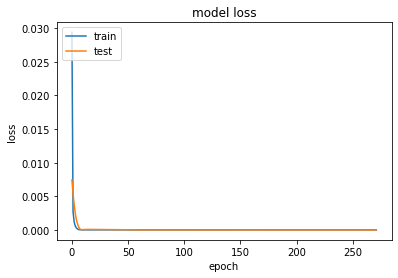

In [26]:
#loss visualization in training and validation
# summarize history for loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()  

Visualize results

In [27]:
#convert string to datetime

def to_datetime(test_date):
  test_datetime = []
  for i in range(len(test_date)):
    date = datetime.datetime.strptime(test_date[i], "%Y.%m.%d%H:%M")
    test_datetime.append(date)
  return test_datetime

test_datetime = to_datetime(test_date)

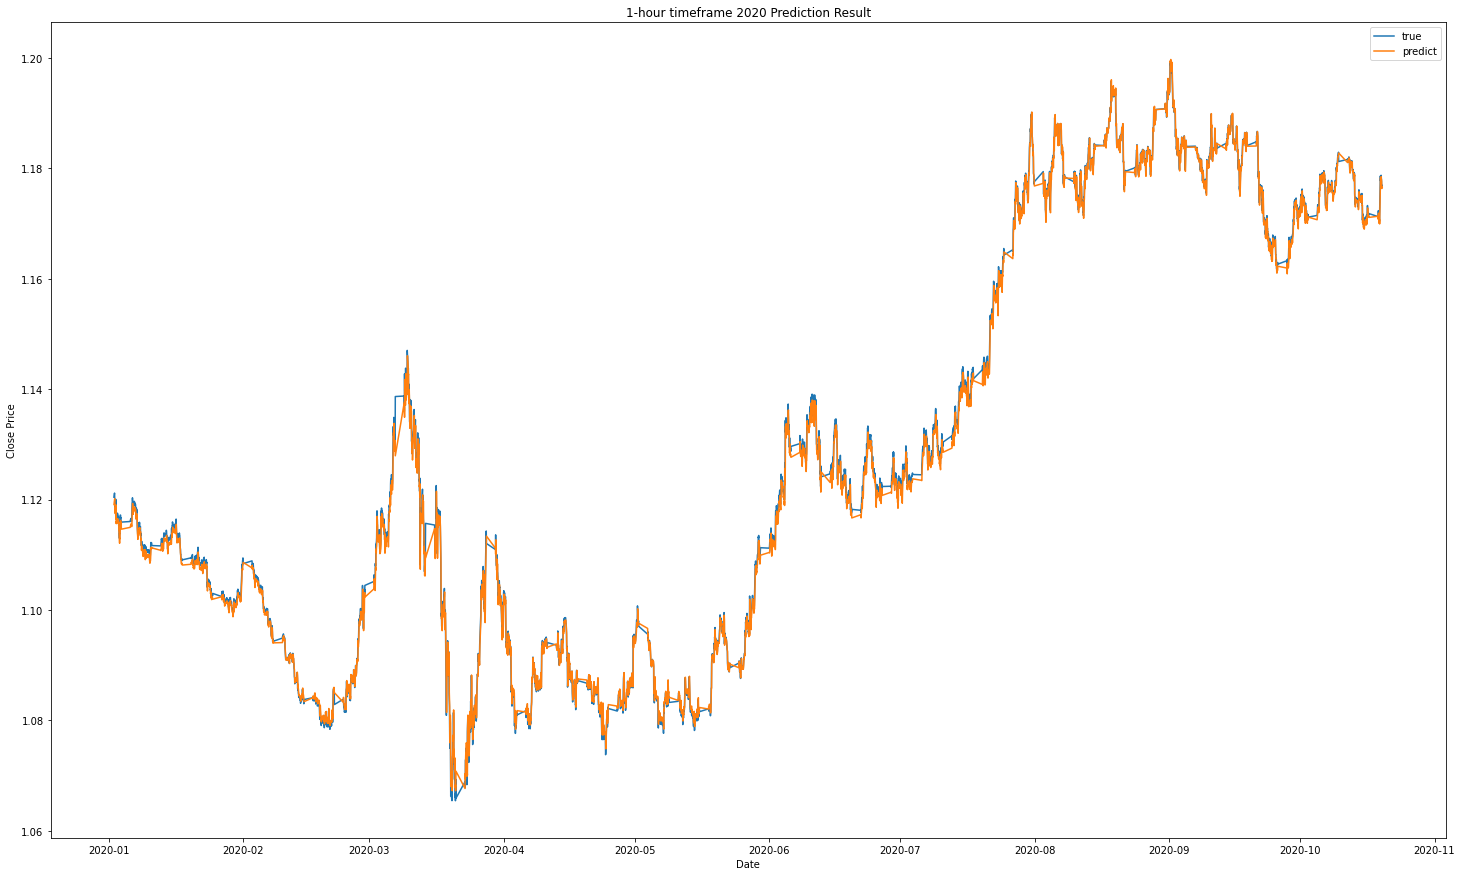

In [28]:
#visualize data

plt.figure(figsize=[25,15])
plt.title('1-hour timeframe 2020 Prediction Result')
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.plot(test_datetime, testY)
plt.plot(test_datetime, predictedTest)
plt.legend(['true', 'predict'], loc='upper right')
plt.show()